In [1]:
import sys
sys.path.insert(0, '/camp/home/maizelr/working/Rory/python_scripts')
from simple_velocity import *
from utils import *

import_my_tools()

/camp/home/maizelr/.local/lib/python3.8/site-packages/dask/config.py:161: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}



        # base packages
        import sys
        import pandas as pd
        import numpy as np
        import scipy as sp      
        import matplotlib.pyplot as plt
        import pickle
        import seaborn as sns
        import pickle
        import adjustText

        # velocity packages
        import scanpy as sc
        import scvelo as scv
        import anndata as ann
        import dynamo as dyn
        import cellrank as cr

        # extra packages
        import plotly as pl
        import plotly.graph_objects as go
        import plotly.express as px
        import ipywidgets as ipy
        


In [2]:
import cellrank as cr

In [3]:
mdata_0 = load_mouse_velocity()
hdata_0 = load_human_velocity()

Loading:  /camp/home/maizelr/working/Rory/transcriptomics/mouse_transcriptomics_data/full_data/new_mouse_velocity_20210121.loom
Variable names made unique.
Loading:  /camp/home/maizelr/working/Rory/transcriptomics/human_transcriptomics_analysis/data/new_human_velocity_20210121.loom
Variable names made unique.


In [4]:
mdata = mdata_0.copy()
sc.pp.normalize_total(mdata, target_sum=1e4)
sc.pp.log1p(mdata)
mdata.strings_to_categoricals()


hdata = hdata_0.copy()
sc.pp.normalize_total(hdata, target_sum=1e4)
sc.pp.log1p(hdata)
hdata.strings_to_categoricals()

... storing 'cell_subtype' as categorical
... storing 'cell_type' as categorical
... storing 'domain' as categorical
... storing 'orig_dataset' as categorical
... storing 'Chromosome' as categorical
... storing 'Strand' as categorical
... storing 'cell_subtype' as categorical
... storing 'cell_type' as categorical
... storing 'domain' as categorical
... storing 'orig_dataset' as categorical
... storing 'region' as categorical
... storing 'sample_id' as categorical
... storing 'timepoint' as categorical
... storing 'Chromosome' as categorical
... storing 'Strand' as categorical


In [5]:
hdata = hdata[hdata.obs.timepoint!='CS17']

In [6]:
m_dict = {'V3':['Nkx2-2','Neurog3','Sim1','Olig3','Sox21','Nkx6-1'],
            'MN':['Olig2','Lhx3','Isl1','Neurog2','Sp8','Nkx6-1','Isl2','Mnx1','Slc10a4','Slc18a3','Sox21'],
            'V2':['Sox21','Gata3','Tal1','Lhx3','Vsx2','Foxn4','Neurog2','Ascl1','Lhx1','Lhx5','Neurog1','Msx1',
                  'Irx3','Irx5','Pax6','Sp8','Nkx6-1','Bhlhe22','Sox14'],
            'V1':['Nkx6-2','En1','Dbx1','Dbx2','Pax2','Otp','Neurog2','Foxd3','Lhx1','Lhx5','Neurog1','Msx1',
                  'Irx3','Irx5','Pax6','Sp8','Prdm12','Pax8'],
            'V0':['Irx3','Irx5','Pax6','Dbx2','Dbx1','Sp8','Lhx1','Lhx5','Evx1','Evx2','Pitx2','Olig3',
                  'Neurog1','Neurog2','Sox21'],
            'dl6':['Pax3','Pax6','Pax7','Irx3','Irx5','Dbx1','Dbx2','Sp8','Lhx1','Lhx5','Pax8','Lbx1','Pax2',
                   'Dmrt3','Wt1','Neurog1','Ascl1','Neurog2','Lbx1','Sox21'],
            'dl5':['Pax3','Pax6','Pax7','Irx3','Irx5','Gsx2','Dbx2','Pou4f1','Tlx3','Prrxl1','Lbx1','Gsx1','Gsx2',
                   'Lmx1b','Ascl1','Sox21'],
            'dl4':['Pax3','Pax6','Pax7','Irx3','Irx5','Gsx2','Ascl1','Gbx2','Gsx1','Lhx1','Lhx5','Pax8','Lbx1',
                   'Pax2','Gbx1','Ptf1a','Neurog1','Sox21'],
            'dl3':['Pax3','Olig3','Pax7','Irx3','Irx5','Pax6','Gsx2','Ascl1','Gbx2','Pou4f1','Tlx3','Isl1','Prrxl1',
                   'Otp','Msx1','Neurog1','Neurog2','Sox21'],
            'dl2':['Pax3','Olig3','Pax7','Irx3','Irx5','Pax6','Msx1','Pou4f1','Foxd3','Lhx1','Lhx5',
                   'Neurog1','Neurog2','Sox21'],
            'dl1':['Pax3','Olig3','Pax7','Irx3','Irx5','Pax6','Msx1','Msx2','Pou4f1','Lhx2','Lhx9','Barhl1','Barhl2',
                   'Atoh1','Sox21']}

h_dict = {}
for key, item in m_dict.items():
    h_dict[key] = [a.upper() for a in item]
    
domains = ['V3','MN','V2','V1','V0','dl6','dl5','dl4','dl3','dl2','dl1']
datas = {'mouse':mdata,'human':hdata}
dictodict = {'mouse':m_dict,'human':h_dict}


def temporal_BROV_genes(data, species, n=2000):
    """ temporally stratified biologically relevant or variable genes"""
    gene_sets = []
    for time in data.obs.timepoint.unique():
        copy = data.copy()
        copy = copy[copy.obs.timepoint==time]
        scv.pp.filter_genes_dispersion(copy, n_top_genes=n)
        tp_genes = copy.var_names  
        gene_sets.append(tp_genes)
    hv_genes = set(gene_sets[0]).intersection(*gene_sets[1:])
    br_genes = gene_list('nt', species=species)
    genes = list(set(hv_genes).union(set(br_genes)))
    genes = list(set(genes).intersection(set(data.var_names)))
    print(len(genes), ' Genes Chosen')
    return genes

In [7]:
def run_dynamics(adata, species, domain, weight, terminal, initial):
    print("Processing {0}...".format(domain))
    dom_data = adata[adata.obs.domain==domain]
    'Selecting Genes...'
    dom_genes = temporal_BROV_genes(dom_data, species, n=2000)
    print('{0} Genes Total.'.format(len(dom_genes)))
    dom_data = dom_data[:,dom_genes]
    scv.pp.moments(dom_data, n_pcs=30, n_neighbors=30)
    scv.tl.recover_dynamics(dom_data)
    scv.tl.velocity(dom_data, mode='stochastic')
    scv.tl.velocity_graph(dom_data)
    scv.tl.velocity_embedding(dom_data, basis='pca')
    scv.tl.latent_time(dom_data)
    sc.tl.rank_genes_groups(dom_data, groupby='cell_type', n_genes=8)
    cr.tl.terminal_states(dom_data, cluster_key='cell_type', weight_connectivities=weight, n_states=terminal);
    cr.tl.initial_states(dom_data, cluster_key='cell_type', n_states=initial)
    cr.tl.lineages(dom_data)
    scv.tl.recover_latent_time(dom_data, root_key='initial_states_probs', end_key='terminal_states_probs')
    fig = plt.figure(figsize=(36,16))
    (ax1, ax2, ax3), (ax4, ax5, ax6)  = fig.subplots(nrows=2, ncols=3)
    scv.pl.velocity_embedding_stream(dom_data, color=['cell_subtype'],
                                     basis='pca', legend_fontsize=22, title=[f'{domain} PCA: Cell Type'], 
                                     smooth=.8, min_mass=4, figsize=(12,8), fontsize=22, dpi=400, ax=ax1, show=False)
    scv.pl.velocity_embedding_stream(dom_data, color=['timepoint'], color_map='gnuplot',
                                     basis='pca', legend_fontsize=12, title=['B. PCA: Timepoint'], 
                                     smooth=.8, min_mass=4, figsize=(12,8), fontsize=22, dpi=400, ax=ax2, show=False)
    scv.pl.velocity_embedding_stream(dom_data, color=['latent_time'],color_map='viridis',
                                     basis='pca', legend_fontsize=12, title=['C. PCA: Latent Time'], 
                                     smooth=.8, min_mass=4, figsize=(12,8), fontsize=22, dpi=400, ax=ax3, show=False)
    cr.pl.terminal_states(dom_data, discrete=True, title='D. Predicted Terminal States', dpi=400,
                          fontsize=22, figsize=(12,8), legend_fontsize=22, size=500, ax=ax4, show=False)
    cr.pl.lineages(dom_data, same_plot=True, show=False, fontsize=22, ax=ax5, dpi=400, title='Lineages')
    cr.pl.initial_states(dom_data, discrete=True, title='F. Predicted Initial State (One Enforced)', dpi=400,
                          fontsize=22, figsize=(12,8), legend_fontsize=22, size=500, ax=ax6, show=False)
    plt.show()
    return dom_data

Trying to set attribute `.obs` of view, copying.


Processing V1...


Trying to set attribute `.obs` of view, copying.


Exctracted 2000 highly variable genes.


Trying to set attribute `.obs` of view, copying.


Exctracted 2000 highly variable genes.
Exctracted 2000 highly variable genes.
395  Genes Chosen
395 Genes Total.
Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:06) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics
    finished (0:00:39) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph


/camp/home/maizelr/.local/lib/python3.8/site-packages/scvelo/tools/dynamical_model.py:683: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/camp/home/maizelr/.local/lib/python3.8/site-packages/scvelo/tools/dynamical_model.py:686: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)



computing latent time using initial_states_probs, terminal_states_probs as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


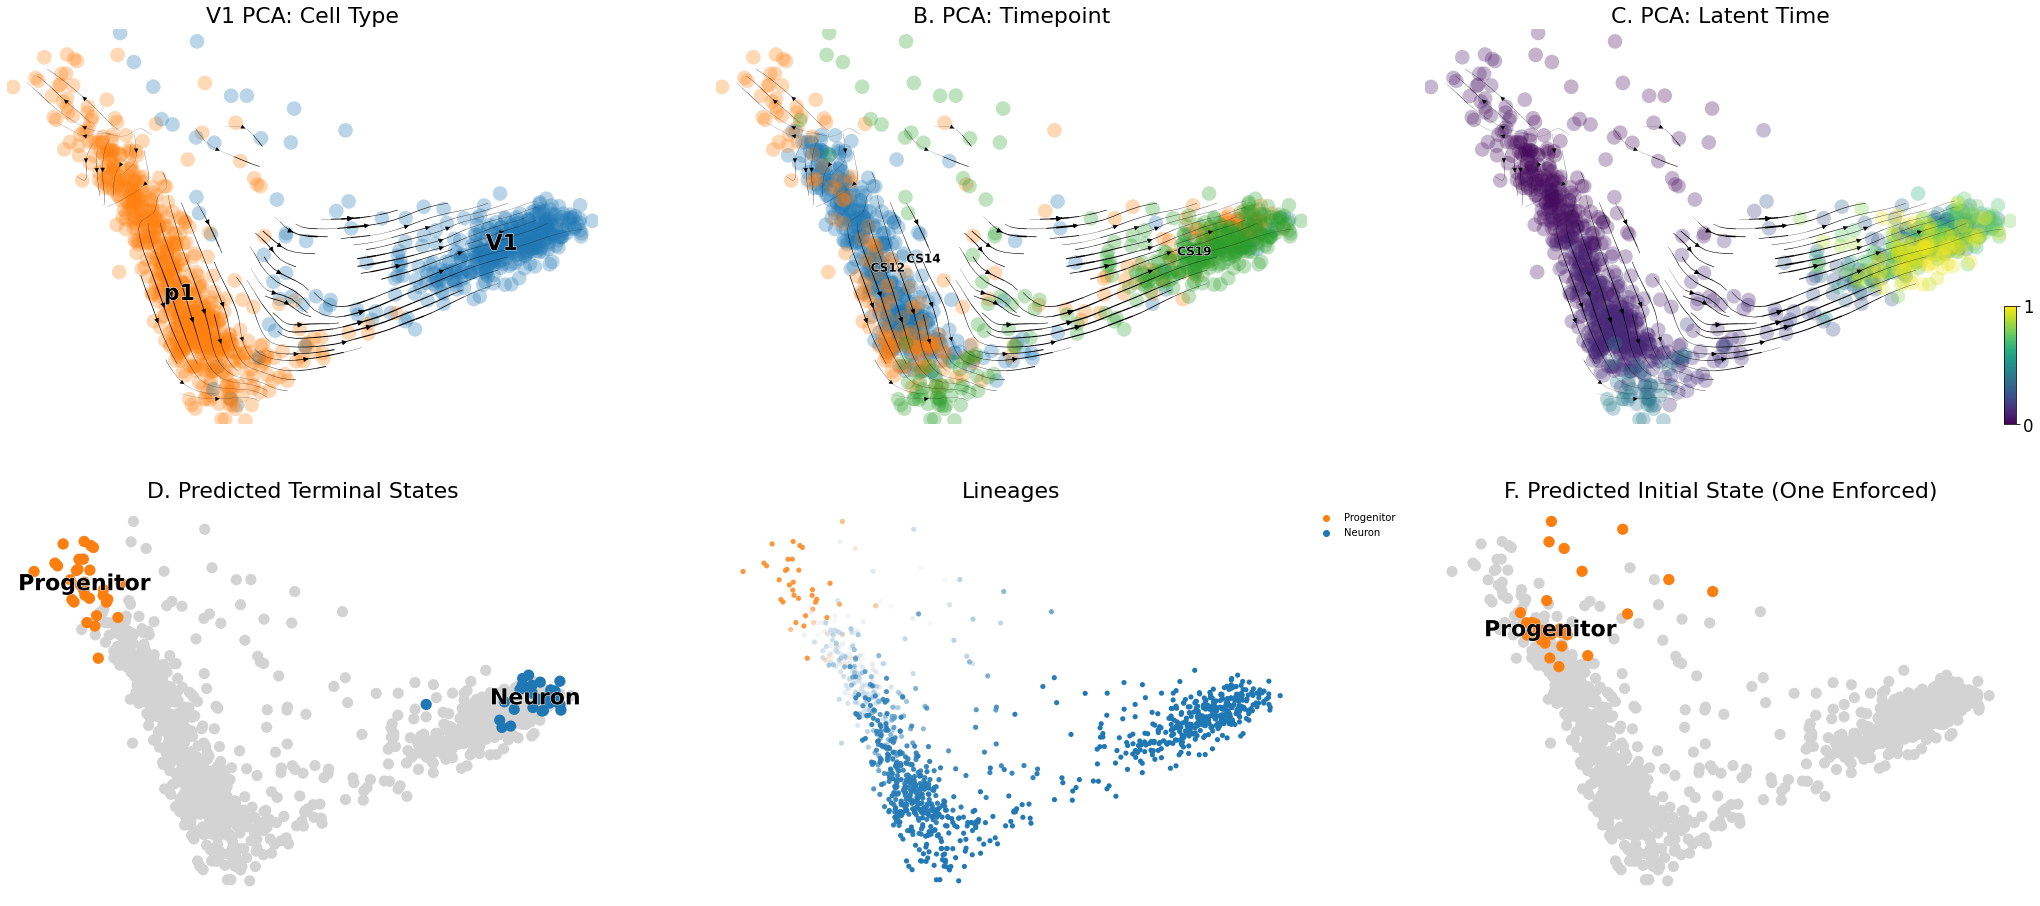

Trying to set attribute `.obs` of view, copying.


Processing V1...


Trying to set attribute `.obs` of view, copying.


Exctracted 2000 highly variable genes.


Trying to set attribute `.obs` of view, copying.


Exctracted 2001 highly variable genes.


Trying to set attribute `.obs` of view, copying.


Exctracted 2000 highly variable genes.


Trying to set attribute `.obs` of view, copying.


Exctracted 2000 highly variable genes.
Exctracted 2000 highly variable genes.
272  Genes Chosen
272 Genes Total.
Normalized count data: spliced, unspliced.
computing neighbors
    finished (0:00:00) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
recovering dynamics
    finished (0:00:42) --> added 
    'fit_pars', fitted parameters for splicing dynamics (adata.var)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)
computing velocity graph


/camp/home/maizelr/.local/lib/python3.8/site-packages/scvelo/tools/dynamical_model.py:683: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.array([dm.alpha, dm.beta, dm.gamma, dm.pars[:3]]) / dm.m[-1]
/camp/home/maizelr/.local/lib/python3.8/site-packages/scvelo/tools/dynamical_model.py:686: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  np.array([dm.t, dm.tau, dm.t_, dm.pars[4]]) * dm.m[-1]


    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_pca', embedded velocity vectors (adata.obsm)
computing terminal states
    identified 1 region of root cells and 2 regions of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)



computing latent time using initial_states_probs, terminal_states_probs as prior
    finished (0:00:00) --> added 
    'latent_time', shared time (adata.obs)


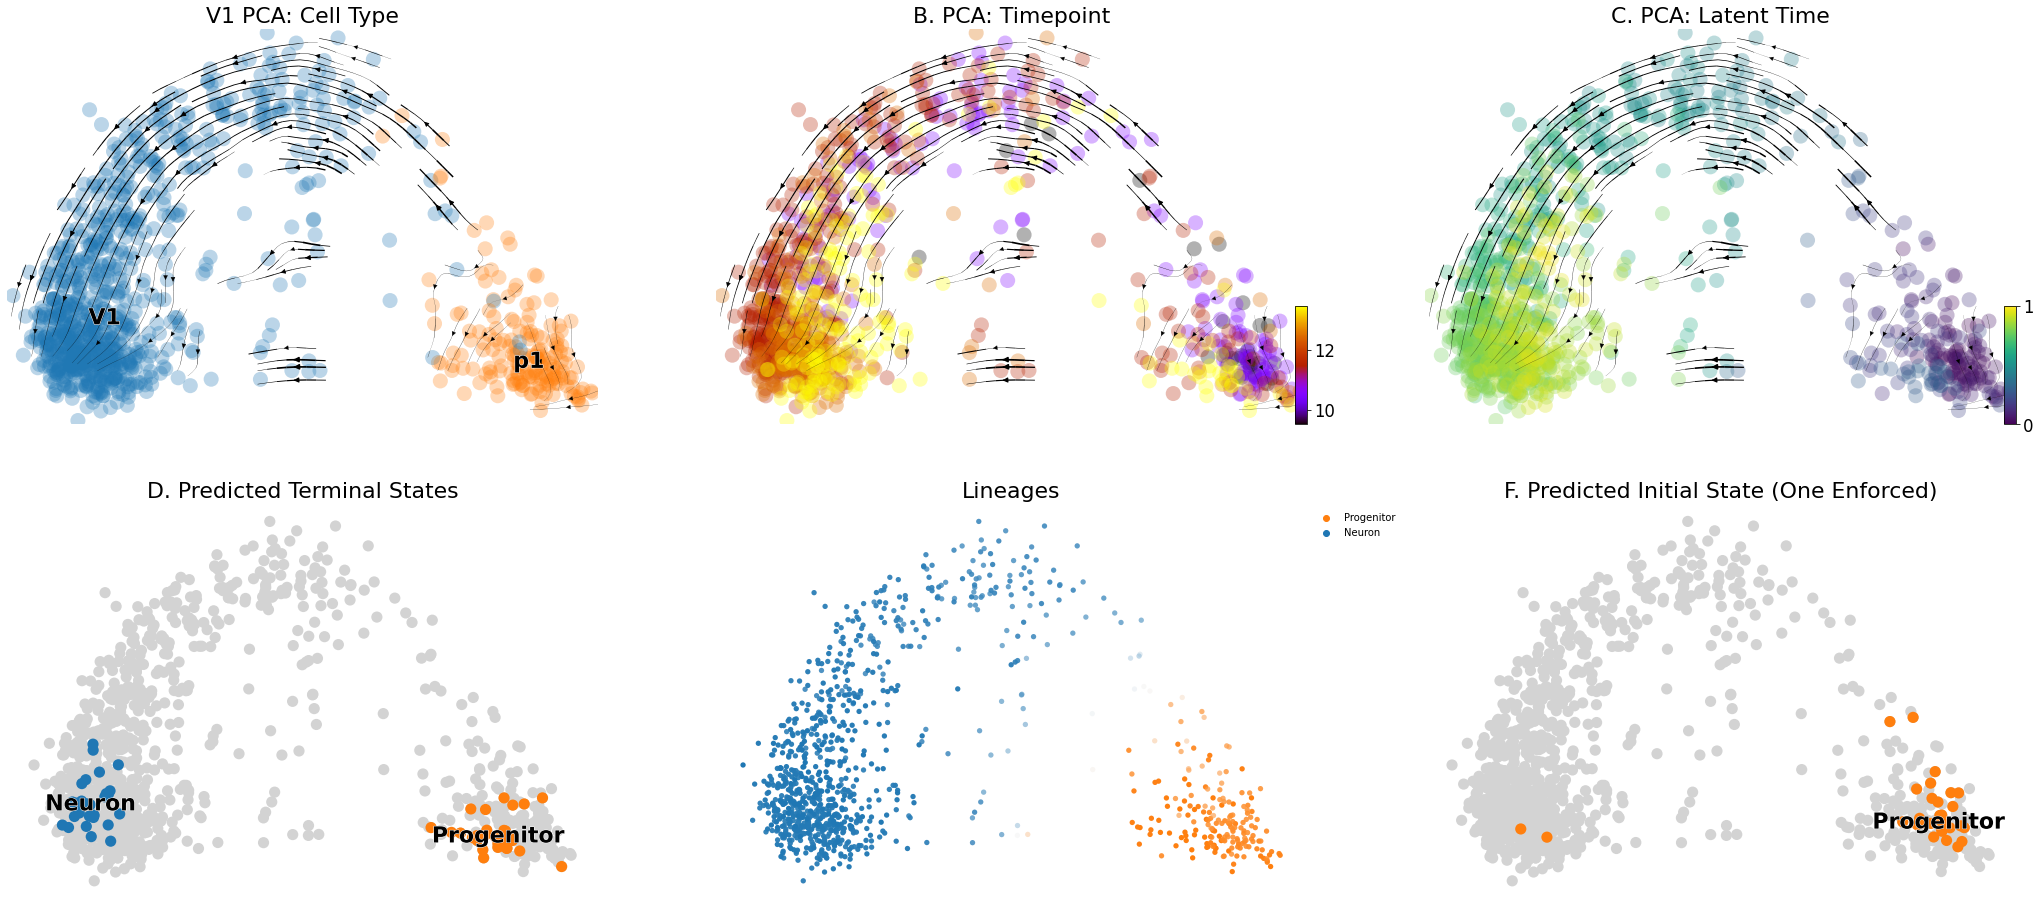

In [8]:
hdom = run_dynamics(hdata, 'human', 'V1', weight=0.2, terminal=2, initial=1)
mdom = run_dynamics(mdata, 'mouse', 'V1', weight=0.2, terminal=2, initial=1)

In [9]:
def get_trends(adata, genes, lineage, norm=False, n_knots=6, n_order=3, n_points=200):
    datmat = np.zeros((len(genes),n_points))
    conint = np.zeros(len(genes))
    failed = np.zeros(len(genes))
    fail = 0
    fgenes = []
    for i, gene in enumerate(genes):
        try:
            model = cr.ul.models.GAM(adata, n_knots=n_knots, spline_order=n_order)
            model.prepare(gene, lineage, n_test_points=n_points)
            model.fit()
            y = model.predict()
            ci = model.confidence_interval()
            c = np.max(np.abs(ci[:,0] - ci[:,1]))
            if norm:
                y = (y-y.min())/(y.max()-y.min())
            datmat[i,:] = y
            conint[i] = c
        except RuntimeError:
            fail += 1
            fgenes.append(gene)
            failed[i] = 1
    print(f"Warning: failed to model {fail} genes:")
    for g in fgenes:
        print(g,end=' ')
    print()
    return datmat, conint, failed

In [10]:
mg = ["Pax6","Nkx6-2","Neurog2","Lhx1","Pax2","En1","Elavl3"]
hg = [g.upper() for g in mg]

hX, hC, hF = get_trends(hdom, hg, 'Neuron', norm=True)
mX, mC, mF = get_trends(mdom, mg, 'Neuron', norm=True)

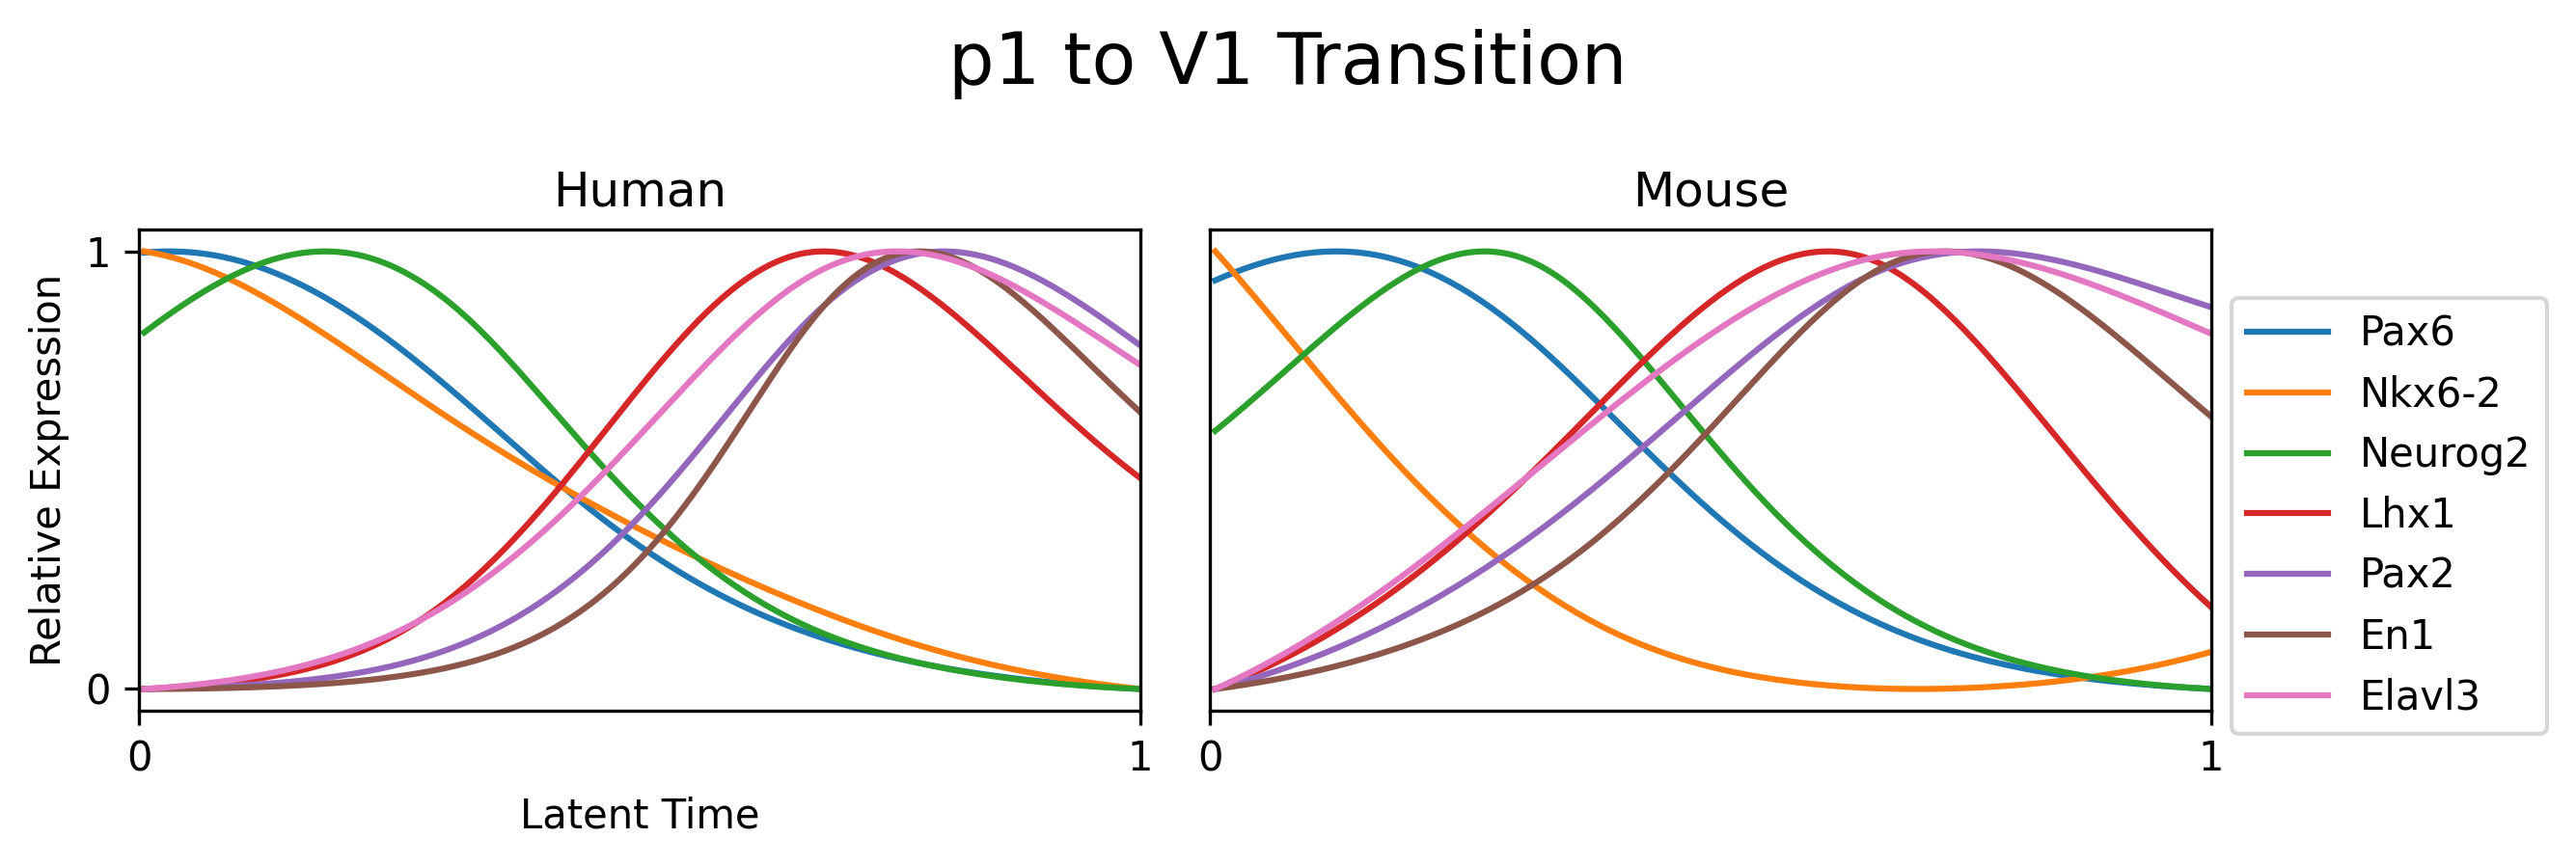

In [11]:
fig = plt.figure(figsize=(9,3), dpi=300)
axes = fig.subplots(1,2)
plt.tight_layout()
ax = axes[0]
for i, g in enumerate(hX):
    ax.plot(np.linspace(1,len(g),len(g)), g)
    ax.set_title("Human")
    ax.set_yticks([0,1])
    ax.set_xticks([0,200])
    ax.set_xticklabels([0,1])
    ax.set_ylabel('Relative Expression')
    ax.set_xlabel('Latent Time')
    ax.set_xlim([0,200])
ax = axes[1]
for i, g in enumerate(mX):
    ax.set_title("Mouse")
    ax.plot(np.linspace(1,len(g),len(g)), g, label=mg[i])
    ax.set_yticks([])
    ax.set_xticks([0,200])
    ax.set_xticklabels([0,1])
    ax.set_xlim([0,200])
plt.legend(bbox_to_anchor=(1, 0.9))
plt.suptitle('p1 to V1 Transition', fontsize=18)
plt.tight_layout()
plt.savefig('../plots/8_supp_V1_transition.png', bbox_inches='tight')
plt.show()